## Histogram of the image values

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import celestializer as cl
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
files = cl.list_observations()
df = cl.raw_to_df(files)

In [4]:
iso_series = cl.grab_series(df, "iso")
n_iso = len(iso_series)
display(iso_series)

print("Load images")
imgs = [
    (row["iso"], cl.RawImage(cl.Paths.data / row["filepath"]).load())
    for _, row in tqdm(iso_series.iterrows(), total=n_iso)
]

,filepath,width,height,focal_length,aperture,shutter,iso,timestamp,camera,bit_depth
33,observations/2024-11-05/IMG_3339.CR2,5202,3465,23.0,3.5,10.0,100,2024-11-05 00:54:11,Canon EOS 1200D,14
32,observations/2024-11-05/IMG_3338.CR2,5202,3465,23.0,3.5,10.0,200,2024-11-05 00:53:53,Canon EOS 1200D,14
31,observations/2024-11-05/IMG_3337.CR2,5202,3465,23.0,3.5,10.0,400,2024-11-05 00:53:29,Canon EOS 1200D,14
30,observations/2024-11-05/IMG_3336.CR2,5202,3465,23.0,3.5,10.0,800,2024-11-05 00:53:09,Canon EOS 1200D,14
29,observations/2024-11-05/IMG_3335.CR2,5202,3465,23.0,3.5,10.0,1600,2024-11-05 00:52:50,Canon EOS 1200D,14
28,observations/2024-11-05/IMG_3334.CR2,5202,3465,23.0,3.5,10.0,3200,2024-11-05 00:52:30,Canon EOS 1200D,14
27,observations/2024-11-05/IMG_3333.CR2,5202,3465,23.0,3.5,10.0,6400,2024-11-05 00:51:48,Canon EOS 1200D,14
34,observations/2024-11-05/IMG_3340.CR2,5202,3465,23.0,3.5,10.0,12800,2024-11-05 00:54:36,Canon EOS 1200D,14


Load images


100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


In [5]:

display(iso_series)

,filepath,width,height,focal_length,aperture,shutter,iso,timestamp,camera,bit_depth
33,observations/2024-11-05/IMG_3339.CR2,5202,3465,23.0,3.5,10.0,100,2024-11-05 00:54:11,Canon EOS 1200D,14
32,observations/2024-11-05/IMG_3338.CR2,5202,3465,23.0,3.5,10.0,200,2024-11-05 00:53:53,Canon EOS 1200D,14
31,observations/2024-11-05/IMG_3337.CR2,5202,3465,23.0,3.5,10.0,400,2024-11-05 00:53:29,Canon EOS 1200D,14
30,observations/2024-11-05/IMG_3336.CR2,5202,3465,23.0,3.5,10.0,800,2024-11-05 00:53:09,Canon EOS 1200D,14
29,observations/2024-11-05/IMG_3335.CR2,5202,3465,23.0,3.5,10.0,1600,2024-11-05 00:52:50,Canon EOS 1200D,14
28,observations/2024-11-05/IMG_3334.CR2,5202,3465,23.0,3.5,10.0,3200,2024-11-05 00:52:30,Canon EOS 1200D,14
27,observations/2024-11-05/IMG_3333.CR2,5202,3465,23.0,3.5,10.0,6400,2024-11-05 00:51:48,Canon EOS 1200D,14
34,observations/2024-11-05/IMG_3340.CR2,5202,3465,23.0,3.5,10.0,12800,2024-11-05 00:54:36,Canon EOS 1200D,14


In [6]:
values = []

for iso, img in tqdm(imgs):
    print(f"Processing ISO {iso}")
    img = img.raw()
    img_in = img.green_interpolated()
    img_in = cl.correct_vignette(img_in)
    img_in = img_in.channel("green")

    mask_hot, mask_dead = cl.find_defects(img_in)
    mask = mask_hot | mask_dead
    img_in = cl.replace_defects(img_in, mask)
    img_in = img_in.green_interpolated()
    img_in -= img_in.min()
    img_in /= img_in.max()
    try:
        for i in range(20):
            tolerance = i * 5 + 3
            print(f"Trying tolerance {tolerance}")
            mask = cl.classify_star_pixels(
                img_in.to_bitdepth(8), tolerance=tolerance
            )
            if mask.sum() < mask.shape[0] * mask.shape[1] * 0.5:
                break
        stars = cl.stars_from_mask(mask)
        values.append(
            {
                "iso": iso,
                "n_dead": mask_dead.sum(),
                "n_hot": mask_hot.sum(),
                "n_stars": len(stars),
                "tolerance": tolerance,
            }
        )
    except Exception as e:
        print(f"Error: {e}")
        values.append(
            {
                "iso": iso,
                "n_dead": mask_dead.sum(),
                "n_hot": mask_hot.sum(),
                "n_stars": -1,
                "tolerance": -1,
            }
        )

df_iso = pd.DataFrame(values)
df_iso

  0%|          | 0/8 [00:00<?, ?it/s]

Processing ISO 100
Trying tolerance 3
Found 33 stars


 12%|█▎        | 1/8 [00:04<00:34,  4.92s/it]

Processing ISO 200
Trying tolerance 3
Trying tolerance 8
Found 20 stars


 25%|██▌       | 2/8 [00:09<00:28,  4.82s/it]

Processing ISO 400
Trying tolerance 3
Found 69 stars


 38%|███▊      | 3/8 [00:14<00:23,  4.67s/it]

Processing ISO 800
Trying tolerance 3
Found 63 stars


 50%|█████     | 4/8 [00:17<00:17,  4.32s/it]

Processing ISO 1600
Trying tolerance 3
Trying tolerance 8
Found 46 stars


 62%|██████▎   | 5/8 [00:21<00:12,  4.05s/it]

Processing ISO 3200
Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Found 28 stars


 75%|███████▌  | 6/8 [00:25<00:07,  3.88s/it]

Processing ISO 6400
Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Trying tolerance 18
Found 65 stars


 88%|████████▊ | 7/8 [00:28<00:03,  3.89s/it]

Processing ISO 12800
Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Trying tolerance 18
Trying tolerance 23
Trying tolerance 28
Trying tolerance 33
Found 79 stars


100%|██████████| 8/8 [00:33<00:00,  4.15s/it]


,iso,n_dead,n_hot,n_stars,tolerance
0,100,0,0,32,3
1,200,0,1,19,8
2,400,0,2,68,3
3,800,0,5,62,3
4,1600,0,6,45,8
5,3200,0,35,27,13
6,6400,86,42,64,18
7,12800,1315,50,78,33


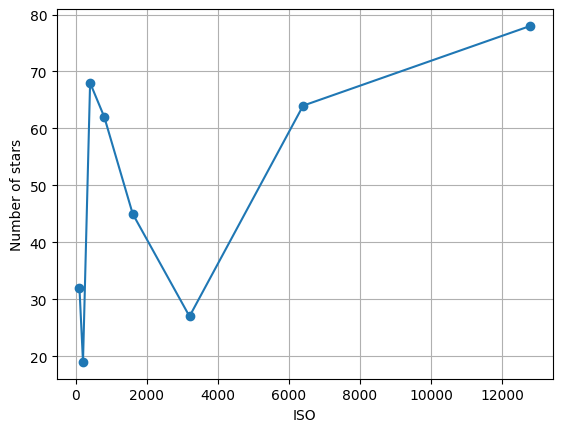

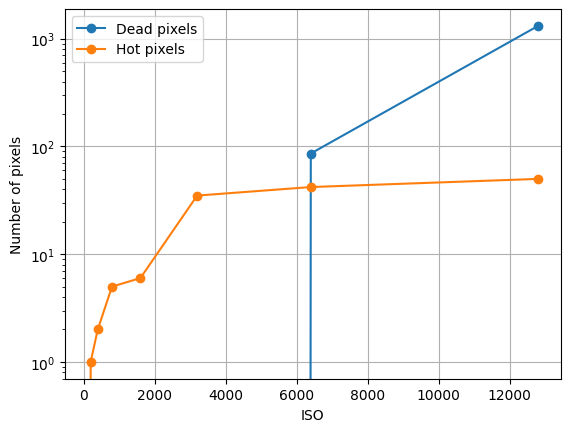

In [7]:
# Plot number of stars
plt.figure()
plt.plot(df_iso["iso"], df_iso["n_stars"], "o-")
plt.xlabel("ISO")
plt.ylabel("Number of stars")
plt.grid()
plt.savefig(cl.Paths.saved / "iso_n_stars.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot number of dead and hot pixels
plt.figure()
plt.plot(df_iso["iso"], df_iso["n_dead"], "o-", label="Dead pixels")
plt.plot(df_iso["iso"], df_iso["n_hot"], "o-", label="Hot pixels")
plt.xlabel("ISO")
plt.ylabel("Number of pixels")
plt.yscale("log")
plt.legend()
plt.grid()
plt.savefig(cl.Paths.saved / "iso_defects.png", dpi=300, bbox_inches="tight")
plt.show()